### Part 2 / Modeling (before MLFlow Deployment)

In [59]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, AdaBoostRegressor

from xgboost import XGBRegressor
from xgboost import to_graphviz, plot_tree

Import data :

In [2]:
data = pd.read_csv('./../Data/get_around_pricing_project.csv')

In [3]:
data.drop('Unnamed: 0', axis=1, inplace=True)

Are there any missing values ? What are the type of features ?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

An overview of the data...

In [5]:
data.describe(include='all')

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
count,4843,4.843000e+03,4843.00000,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843,4843.000000
unique,28,NaN,NaN,4,10,8,2,2,2,2,2,2,2,NaN
top,Citroën,NaN,NaN,diesel,black,estate,True,True,False,False,False,False,True,NaN
freq,969,NaN,NaN,4641,1633,1606,2662,3839,3865,3881,2613,3674,4514,NaN
mean,NaN,1.409628e+05,128.98823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.214536
std,NaN,6.019674e+04,38.99336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.568268
min,NaN,-6.400000e+01,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,1.029135e+05,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.000000
50%,NaN,1.410800e+05,120.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.000000
75%,NaN,1.751955e+05,135.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.000000


For 'mileage', we have a negative value (-6.4)... It's a error !

The max of the two numerical features are very stranged... Let's see the distributions...

In [6]:
fig = px.histogram(data['mileage'], marginal='box', nbins=200)
fig.show()

This seems to be a normal distribution, slightly asymmetrical (rental cars become scarce faster at a certain age).
Many outliers, after about 300 miles !...
Some of these extreme toolers (1000 miles!) seem to be absurd and impossible. Let's take a closer look at an example...

In [8]:
data.loc[data['mileage']>1000000,:]

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
3732,Citroën,1000376,90,diesel,black,subcompact,True,False,False,False,False,False,True,37


It's probably an error ... or not... but it's an amazing case ! 

In [9]:
fig = px.histogram(data['engine_power'], marginal='box', nbins=200)
fig.show()

For 'engine_power', it's not a normal distribution... Here again, we probably have some strange outliers, especially in the smaller values (they are not bikes or pushcarts after all!)

In [11]:
data.loc[data['engine_power']>350,:]

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
3601,Mini,150187,412,petrol,white,sedan,True,True,True,False,True,True,True,204
4146,Suzuki,2970,423,petrol,red,suv,True,True,True,False,False,False,True,287


Luxury cars ?

In [12]:
data.loc[data['engine_power']<70,:]

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
1796,Porsche,152328,25,hybrid_petrol,black,hatchback,False,True,False,False,False,False,True,142
1925,Porsche,152470,25,hybrid_petrol,black,hatchback,False,True,False,False,False,False,True,124
2390,Peugeot,170529,66,diesel,silver,hatchback,False,False,True,False,False,False,False,32
2771,Renault,146951,66,petrol,white,sedan,False,False,False,False,False,False,False,36
3765,Nissan,81770,0,diesel,white,suv,False,False,False,False,False,False,False,108


Very strange 'engine_power' values... There could be errors...

We therefore decide to eliminate a very small part of the outliers, only the absurd values (distance from the mean is greater than 3 standard deviations), for the two numericals features.

In [10]:
data['engine_power'].std()

38.993359693581844

In [13]:
to_keep = (abs(data['engine_power'] - data['engine_power'].mean()) <= 3*data['engine_power'].std()) & (data['engine_power']>50)
data = data.loc[to_keep,:]

In [7]:
data['mileage'].std()

60196.740702514515

In [14]:
to_keep = (abs(data['mileage'] - data['mileage'].mean()) <= 3*data['mileage'].std()) & (data['mileage']>=0)
data = data.loc[to_keep,:]

Verification of min and max values :

In [15]:
data.describe()

,mileage,engine_power,rental_price_per_day
count,4747.000000,4747.000000,4747.000000
mean,139052.917422,127.491679,120.943122
std,54722.444701,35.534100,32.134878
min,476.000000,66.000000,10.000000
25%,102870.000000,100.000000,104.000000
50%,140623.000000,120.000000,119.000000
75%,174703.000000,135.000000,136.000000
max,321498.000000,240.000000,422.000000


It is much more coherent

Let's see the distribution of our target :

In [16]:
fig = px.histogram(data['rental_price_per_day'], marginal='box', nbins=100)
fig.show()

It seems to be a normal distribution, with irregularities. 

Here too we have outliers. Are these absurd values?

In [17]:
data.loc[data['rental_price_per_day'] > 300,:]

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
90,Renault,12402,170,hybrid_petrol,grey,coupe,True,True,False,False,False,False,False,309
4684,SEAT,103222,140,diesel,grey,suv,True,True,False,False,True,False,True,378
4753,BMW,72515,135,diesel,blue,suv,False,False,True,False,False,False,False,422


Probably not. One of them is a gasoline hybrid, a coupe... The others are a SEAT SUV (very trendy?) and a BMW SUV... luxury cars?

Finally, we could observe correlations... If we have to choose some features to remove, what would be the best choice?

<AxesSubplot:>

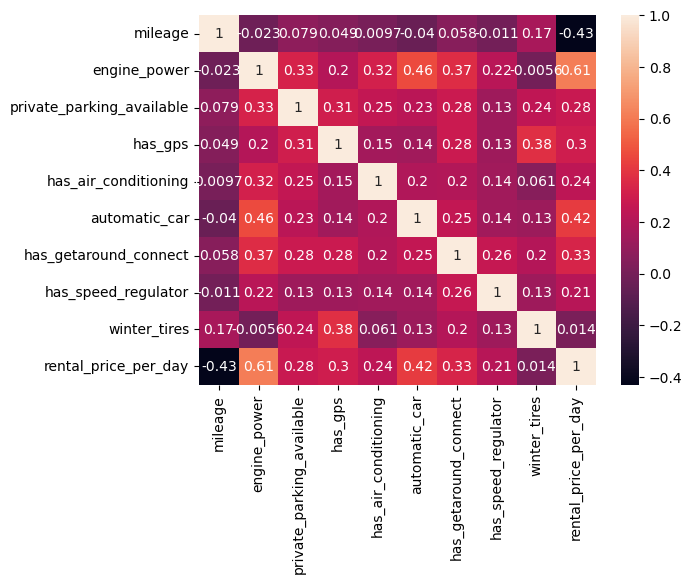

In [18]:
data_corr = data.corr()
sns.heatmap(data_corr, annot=True)

There are a lot of correlations between all the features, and with our target... So, if we can, we would like to keep all the features...

But in the correlation graph, the categorical features (not boulean) are missing... Let's see them, in function of our target :

In [19]:
fig = px.box(data, x='fuel', y='rental_price_per_day')
fig.show()

'Fuel' seems to be a determining factor for the choice of the rental price...

In [20]:
fig = px.box(data, x='paint_color', y='rental_price_per_day')
fig.show()

'Paint_color' is a little less important, but still... (People seems to hate green color)

In [21]:
fig = px.box(data, x='car_type', y='rental_price_per_day')
fig.show()

'Car_type' have an importance in the rental price...

In [22]:
fig = px.box(data, x='model_key', y='rental_price_per_day')
fig.show()

and 'model' too ! It's logical...

Conclusion : we decide not to remove any features. (if we can)

-------------

PREPROCESSING

First, we try to do feature engineering :

Perhaps the square of 'mileage' or 'engine_power'... or the inverse... are best representative than the value :

In [23]:
numeric_init = ['mileage','engine_power']
numericals = numeric_init.copy()

for col in numeric_init:
    data[f'{col}_2'] = data[col]**2
    data[f'{col}_inv'] = 1 / data[col]
    numericals.append(f'{col}_2')
    numericals.append(f'{col}_inv')

Splitting into data and target :

In [24]:
data_x = data.drop('rental_price_per_day', axis=1)
y = data['rental_price_per_day']

In [25]:
data_x

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,mileage_2,mileage_inv,engine_power_2,engine_power_inv
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,19715248921,0.000007,10000,0.010000
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,33597790209,0.000005,14400,0.008333
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,16392961225,0.000008,18225,0.007407
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,9427827409,0.000010,25600,0.006250
5,Citroën,152352,225,petrol,black,convertible,True,True,False,False,True,True,True,23211131904,0.000007,50625,0.004444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,Toyota,39743,110,diesel,black,van,False,True,False,False,False,False,True,1579506049,0.000025,12100,0.009091
4839,Toyota,49832,100,diesel,grey,van,False,True,False,False,False,False,True,2483228224,0.000020,10000,0.010000
4840,Toyota,19633,110,diesel,grey,van,False,True,False,False,False,False,True,385454689,0.000051,12100,0.009091
4841,Toyota,27920,110,diesel,brown,van,True,True,False,False,False,False,True,779526400,0.000036,12100,0.009091


Splitting into train and test set :

In [26]:
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2, random_state=42)

Define and applying the preprocessing :

In [27]:
categoricals = data_x.columns.drop(numericals)

In [28]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numericals),
    ('cat', OneHotEncoder(drop='first'), categoricals)
])

In [29]:
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

------------------

MODEL 1 : BASELINE (RIDGE)

Because we know we have a lot of features, we try directly a Ride Regression as a baseline model...

In [30]:
model = Ridge()

params = {
    'alpha': [0.008, 0.009, 0.01]
}
grid = GridSearchCV(model, param_grid=params, scoring='r2', cv=5)

Note : here, we indicate the final 'params' ... (we processed by we proceed by dichotomy, back and forth...)

In [31]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.008, 0.009, 0.01]}, scoring='r2')

In [32]:
grid.best_estimator_

Ridge(alpha=0.009)

In [33]:
y_pred = grid.best_estimator_.predict(x_train)
r2_score(y_train, y_pred)

0.6941616034374254

In [34]:
y_pred_test = grid.best_estimator_.predict(x_test)
r2_score(y_test, y_pred_test)

0.7321432016582315

In [35]:
train_preds = cross_val_score(grid.best_estimator_, x_train, y_train, cv=5)
print(f'Mean on train set : {train_preds.mean()}')
print(f'Std on train set : {train_preds.std()}')

Mean on train set : 0.6817815281557239
Std on train set : 0.028807338029299245


In [36]:
test_preds = cross_val_score(grid.best_estimator_, x_test, y_test, cv=5)
print(f'Mean on train set : {test_preds.mean()}')
print(f'Std on train set : {test_preds.std()}')

Mean on train set : 0.671083263572131
Std on train set : 0.035761113979902816


We don't have any overfitting... (because we used Ridge)

Let's see the feature extraction :

In [37]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())

In [38]:
feats_imp = pd.DataFrame(grid.best_estimator_.coef_, index = col_names)

In [39]:
fig = px.bar(feats_imp )
fig.show()

The model relies heavily on the brand of the car, but also the power of the car and the mileage of the car... Our strange formulas of square and inverse of 'engine_power' seem to be useful too.

-------------------

MODEL 2 : HIST GRADIENT BOOSTING REGRESSOR

We want to try a ensemble model... Because we have a medium/large dataset, we tried an Histogram-based Gradient Boosting Regression Tree, implemented in sk-learn and inspired by the [LightGBM]('https://github.com/Microsoft/LightGBM') model :

"
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data. "

In [40]:
model = HistGradientBoostingRegressor()

params = {
    'max_depth': [14, 15, 16],
    'max_leaf_nodes':[37, 40, 42],
    'min_samples_leaf': [5, 6, 8]
    }

grid = GridSearchCV(model, param_grid=params, cv=5, verbose=2, n_jobs=-1, scoring='r2')

Note : here, we indicate the final 'params' ... (we processed by we proceed by dichotomy, back and forth...)

In [41]:
grid.fit(x_train.toarray(), y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [14, 15, 16],
                         'max_leaf_nodes': [37, 40, 42],
                         'min_samples_leaf': [5, 6, 8]},
             scoring='r2', verbose=2)

Note : We need to use the 'toarray()' function... because this model doesn't accept a sparse matrix as input...

In [42]:
grid.best_estimator_

HistGradientBoostingRegressor(max_depth=15, max_leaf_nodes=40,
                              min_samples_leaf=6)

In [43]:
y_pred = grid.best_estimator_.predict(x_train.toarray())
r2_score(y_train, y_pred)

0.889988554510355

In [44]:
y_pred_test = grid.best_estimator_.predict(x_test.toarray())
r2_score(y_test, y_pred_test)

0.8051684638752936

Very good performances... with a lot of overfitting ! But when we look the 'cross val score' :

In [45]:
train_preds = cross_val_score(grid.best_estimator_, x_train.toarray(), y_train, cv=5)
print(f'Mean on train set : {train_preds.mean()}')
print(f'Std on train set : {train_preds.std()}')

Mean on train set : 0.741469723571423
Std on train set : 0.03580697435686926


In [46]:
test_preds = cross_val_score(grid.best_estimator_, x_test.toarray(), y_test, cv=5)
print(f'Mean on train set : {test_preds.mean()}')
print(f'Std on train set : {test_preds.std()}')

Mean on train set : 0.719042802009761
Std on train set : 0.028453691097275587


The performances are a bit degraded...

------------

MODEL 3 : XG BOOST REGRESSOR

We try here another sequential ensemble model : famous XGBoost... faster than the previous model !

In [49]:
model = XGBRegressor()

params = {
    'eta' : [0.1],
    'max_depth' : [4, 6, 8],
    'n_estimators' : [150, 170, 200],
    
}

grid2 = GridSearchCV(model, param_grid=params, verbose=2, n_jobs=-1, cv=5)

In [51]:
grid2.fit(x_train.toarray(), y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
 

In [52]:
grid2.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.100000001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=170, n_jobs=0,
             num_parallel_tree=1, predictor='auto', ...)

In [53]:
y_pred = grid2.best_estimator_.predict(x_train.toarray())
r2_score(y_train, y_pred)

0.9024226158199593

In [54]:
y_pred_test = grid2.best_estimator_.predict(x_test.toarray())
r2_score(y_test, y_pred_test)

0.7978266304339974

In [55]:
test_preds = cross_val_score(grid2.best_estimator_, x_test.toarray(), y_test, cv=5)
print(f'Mean on train set : {test_preds.mean()}')
print(f'Std on train set : {test_preds.std()}')

Mean on train set : 0.7288515840269337
Std on train set : 0.04149067029543838


Performances on a cross val score are better...

Feature extraction :

In [58]:
feats_imp = pd.DataFrame(grid2.best_estimator_.feature_importances_, index = col_names)
fig = px.bar(feats_imp)
fig.show()

Our XG Boost model don't care about our strange formulas (square or inverse of 'mileage' and 'engine_power')

All the other features have a relative importance... 'Engine_power' have a very large importance...

Conclusion : we decided to deploy this last model. Because it seems faster and stronger than the others...

-----------

PREPARATION FOR MLFOW DEPLOYMENT

Here we try to package the preprocessor and the xgboost model with a sklearn pipeline (So, our deployed model will be a sklearn model).

We take the opportunity to reduce the overfitting a bit, experimenting with parameters like 'gamma', 'min_child_weight', 'colsampe_bytree'... according to the xgboost documentation.

We need to go back to a previous step of preprocessing, when data was a dataframe (and not a sparse matrix) :

In [104]:
x_train, x_test, y_train, y_test = train_test_split(data_x, y, test_size=0.2, random_state=42)

In [162]:
xgb_model = XGBRegressor(eta=0.1, n_estimators=170, min_child_weight=2, gamma=0.8, colsample_bytree=0.4)

Here we build the pipeline :

In [163]:
model_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('prediction', xgb_model)
])


model_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['mileage', 'engine_power',
                                                   'mileage_2', 'mileage_inv',
                                                   'engine_power_2',
                                                   'engine_power_inv']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['model_key', 'fuel', 'paint_color', 'car_type',
       'private_parking_available', 'has_gps', 'has_air_conditioning',
       'automatic_car', 'has_get...
                              eval_metric=None, feature_types=None, gamma=0.8,
                              gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                   

And test it :

In [172]:
y_pred = model_pipeline.predict(x_train)
y_pred_test = model_pipeline.predict(x_test)

In [173]:
r2_score(y_train, y_pred)

0.8923654976122435

In [174]:
r2_score(y_test, y_pred_test)

0.8044447096205319

We have reduced a little the overfitting... Let's seen on the cross val score :

In [175]:
test_preds = cross_val_score(xgb_model, preprocessor.transform(x_test), y_test, cv=5)
print(f'Mean on train set : {test_preds.mean()}')
print(f'Std on train set : {test_preds.std()}')

Mean on train set : 0.7354641555508314
Std on train set : 0.027384590345803293


Note : for the 'cross val score' we need to use independently the xgboost model and the proprocesssor, because if we don't, we have an error, due to the categoricals features. (preprocessor is automaticly used with a 'fit_transform' and we want just used a 'transform'...)

Test with a sample :

In [182]:
sample_data = data_x.sample(5)

In [183]:
sample_data 

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,mileage_2,mileage_inv,engine_power_2,engine_power_inv
2139,Mercedes,43550,100,diesel,white,hatchback,False,True,False,False,False,False,True,1896602500,0.000023,10000,0.010000
4398,BMW,198866,230,diesel,silver,suv,True,True,False,True,True,True,True,39547685956,0.000005,52900,0.004348
1120,Audi,125242,160,diesel,grey,estate,False,True,False,True,True,False,True,15685558564,0.000008,25600,0.006250
2999,Citroën,167593,135,diesel,black,sedan,False,True,False,False,True,True,True,28087413649,0.000006,18225,0.007407
3126,Audi,150586,190,diesel,black,sedan,True,True,False,False,False,True,True,22676143396,0.000007,36100,0.005263


In [184]:
model_pipeline.predict(sample_data)

array([138.39232, 143.4008 , 140.75252, 126.58448, 156.03008],
      dtype=float32)